## Heuristic optimizations
There are multiple tweaks needed to get the final product working as desired. 

[Validation of pipeline](#section00)

[Simple penalty function](#section0)

[Fixing clusterwise optimization](#section0.5)

[Exclusion of areas in Noord](#section1)

In [1]:
import sys
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely

sys.path.append("../")

from Code.helper_functions import initial_loading, analyze_candidate_solution,\
add_shortest_distances_to_all_households, calculate_weighted_distance, calculate_penalties,\
join_api_db, containers_per_cluster
from Code.loading_data import distance_matrix_with_counts, load_api_data,\
create_all_households, create_aansluitingen, load_geodata_containers, address_in_service_area
from Code.algorithms import clusterwise_optimization, random_start_hillclimber, random_shuffling_clusters

POSTGRES password?WelkomCorne!


<a id='section00'></a>
## Validation of pipeline

There were a lot of small problems with the initial pipeline, which resulted in a need to validate all parts of this:
- amount of households per bag --> fixed
- total households --> fixed
- average walking distance update --> fixed
- Check amount of households in total --> fixed
- Exclude households that have more than 1000 meters walking distance --> fixed (optional parameter)


- locations
- Exclusion of some rural areas (Ransdorp, Durgerdam etc.)
- Penalties
- Search for rural areas and exclude those possibly


In [ ]:
rel_poi_df = pd.read_csv('../Data/postgres_db/info_pois.csv', index_col='Unnamed: 0')
rel_poi_df.head()
# rel_poi_df = rel_poi_df[['bk_afv_rel_nodes_poi','s1_afv_nodes', 's1_afv_poi', 'cluster_x', 'cluster_y', 'type', 'bag']]

In [ ]:
# rel_poi_df['bag'].value_counts()
# rel_poi_df[rel_poi_df['bag'] == '363100012241555']
# df = pd.read_csv('../Data/households_per_cluster.csv')
# df[df['ligtin_bag_pnd_identificatie'] == '0363100012241555']
info_poi = pd.read_csv('../Data/postgres_db/afv_poi.csv')
temp = rel_poi_df.groupby('bag').first().reset_index().rename(columns={0:'bag'})

In [ ]:
inpt_dfob = pd.read_csv('../Data/postgres_db/addresses_per_cluster.csv')
inpt_dis = pd.read_csv('../Data/postgres_db/distance_matrix.csv')

In [ ]:
df_afstandn2 = distance_matrix_with_counts(inpt_dfob=inpt_dfob,
                                                       inpt_poi=rel_poi_df,
                                                       inpt_dis=inpt_dis,
                                                       get_data=False)

In [ ]:
api_df = load_api_data(subsectie=None)

In [ ]:
all_households = create_all_households(rel_poi_df, subsectie=None)\
    .rename(columns={'s1_afv_nodes': 'naar_s1_afv_nodes'})

In [ ]:
joined = join_api_db(rel_poi_df, api_df)

In [ ]:
joined['rest'], joined['plastic'], joined['papier'], joined['glas'], \
    joined['textiel'], joined['totaal'] = zip(*joined['aantal_per_fractie']
                                              .apply(lambda x:
                                              containers_per_cluster(x)))

In [ ]:
polygon_list = load_geodata_containers()
joined['move_rest'] = joined.apply(lambda row: address_in_service_area
                                   (row['cluster_x'], row['cluster_y'],
                                    polygon_list=polygon_list),
                                       axis=1)

In [ ]:
joined = joined[joined['totaal'] <= 8].reset_index()
joined = joined.drop(['index'], axis=1)

# joined

In [2]:
# automatic
all_households, rel_poi_df, joined, df_afstandn2 = initial_loading()

Do you want to use addresses instead of clusters?True
What stadsdeel do you want to make as a subsection(optional parameter)?
What is the maximum amount of containers in a cluster that is considered to be useful?8
Where to get db files(local/online)?local
DB relation POIs loaded


..\Code\loading_data.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ligtin_bag_pnd_identificatie'] = \
..\Code\loading_data.py:397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verblijfsobjecten['bag'] = verblijfsobjecten.loc[:, 'bag']\


distance matrix loaded
API data loaded
Table all households created
API and DB joined
containers per cluster determined
move_rest determined


In [3]:
# analyze_candidate_solution(joined, all_households, rel_poi_df, df_afstandn2, clean=False, use_count=True)
joined['rest'], joined['plastic'], joined['papier'], joined['glas'], \
    joined['textiel'], joined['totaal'] = zip(*joined['aantal_per_fractie']
                                              .apply(lambda x:
                                              containers_per_cluster(x)))

In [4]:
# Check for validity

# df_afstandn2.groupby('naar_s1_afv_nodes').first()['count'].sum()
# joined[joined['move_rest'] == False]['stadsdeel'].value_counts()
# joined[joined['move_rest'] == False]['rest'].sum()

In [5]:
joined_cluster_distance = joined.set_index('s1_afv_nodes')\
    .join(df_afstandn2.set_index('van_s1_afv_nodes')).reset_index()\
    .rename(columns={'index':'van_s1_afv_nodes'})

In [6]:
good_result = add_shortest_distances_to_all_households(all_households,
                                                      joined_cluster_distance,
                                                      use_count=True)
good_result['rest_afstand'].isna().sum()

47216

In [7]:
good_result['count'] = good_result['count'].fillna(0)
good_result[['poi_rest', 'poi_plastic', 'poi_papier', 'poi_glas', 'poi_textiel']] = good_result[['poi_rest', 'poi_plastic', 'poi_papier', 'poi_glas', 'poi_textiel']].fillna(999)
good_result[['rest_afstand', 'plastic_afstand', 'papier_afstand', 'glas_afstand', 'textiel_afstand']] = good_result[['rest_afstand', 'plastic_afstand', 'papier_afstand', 'glas_afstand', 'textiel_afstand']].fillna(2000)


good_result.loc[~good_result['uses_container'],
                        'rest_afstand'] = np.nan
good_result.loc[~good_result['uses_container'], 'poi_rest'] = np.nan

good_result.loc[good_result['collect_cardboard'], 'papier_afstand'] = np.nan
good_result.loc[good_result['collect_cardboard'], 'poi_papier'] = np.nan

In [8]:
good_result

,cluster_x,cluster_y,uses_container,collect_cardboard,in_landelijk_noord,in_centrum,in_neigborhood,count,poi_rest,rest_afstand,poi_plastic,plastic_afstand,poi_papier,papier_afstand,poi_glas,glas_afstand,poi_textiel,textiel_afstand
naar_s1_afv_nodes,,,,,,,,,,,,,,,,,,
483489,119757,488187,True,False,False,False,True,5.0,527392.0,49.41,718501.0,297.63,527392.0,49.41,527392.0,49.41,622813.0,366.49
483491,128330,485171,True,False,False,False,True,1.0,603871.0,45.37,563386.0,191.53,563386.0,191.53,563386.0,191.53,563386.0,191.53
483492,116782,485130,True,False,False,False,True,6.0,790214.0,130.99,854113.0,203.94,579259.0,195.81,854113.0,203.94,743514.0,305.62
483497,126721,481159,True,False,False,False,True,496.0,785277.0,51.68,520452.0,588.29,689543.0,489.10,689543.0,489.10,958308.0,692.23
483498,119059,486577,True,False,False,False,True,7.0,637963.0,12.99,800188.0,122.73,714362.0,292.18,714362.0,292.18,860040.0,477.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966954,119052,481924,True,False,False,False,True,1.0,915296.0,22.52,919134.0,250.59,619463.0,104.80,619463.0,104.80,919134.0,250.59
966959,122388,485556,True,False,False,False,True,2.0,794012.0,57.87,779826.0,323.02,853410.0,167.04,794012.0,57.87,612953.0,342.26
966964,122495,488927,True,False,False,False,True,2.0,568456.0,111.34,693329.0,195.67,928066.0,121.05,858795.0,208.63,918198.0,755.34


In [ ]:
aansluitingen = create_aansluitingen(good_result, joined_cluster_distance, use_count=True)

In [ ]:
(good_result['rest_afstand'] * good_result['count']).sum()/good_result['count'].sum()

In [ ]:
def calculate_weighted_distance(good_result, use_count=False, w_rest=0.61,
                                w_plas=0.089, w_papi=0.16, w_glas=0.11,
                                w_text=0.025, return_all=False):
    """
    Calculate weighted distance of an input dataframe.

    Function to calculated the weighted average walking distance as part of the
    score function. It calculates the mean difference per fraction and employs
    the weights assigned to them to combine it into a single score.

    Input:
    df_containing distance from all households to its nearest container
    per fraction (known as good_result)

    Output:
    float representing weighted average distance
    """
    if not use_count:
        rest_mean = good_result['rest_afstand'].mean()
        papier_mean = good_result['papier_afstand'].mean()
        glas_mean = good_result['glas_afstand'].mean()
        plastic_mean = good_result['plastic_afstand'].mean()
        textiel_mean = good_result['textiel_afstand'].mean()
    else:
        rest_mean = (good_result['rest_afstand'] * good_result['count'])\
            .sum() / good_result['count'].sum()
        papier_mean = (good_result['papier_afstand'] * good_result['count'])\
            .sum() / good_result['count'].sum()
        plastic_mean = (good_result['plastic_afstand'] * good_result['count'])\
            .sum() / good_result['count'].sum()
        glas_mean = (good_result['glas_afstand'] * good_result['count'])\
            .sum() / good_result['count'].sum()
        textiel_mean = (good_result['textiel_afstand'] * good_result['count'])\
            .sum() / good_result['count'].sum()

    if return_all:  # Return all individual mean distances (for analysis)
        return rest_mean, plastic_mean, papier_mean, glas_mean, textiel_mean

    # Multiply mean distance per fraction with its relative importance
    score = w_rest * rest_mean + w_plas * plastic_mean + w_papi * papier_mean + \
        w_glas * glas_mean + w_text * textiel_mean
    return score

In [ ]:
avg_distance = calculate_weighted_distance(good_result,
                                           use_count=True,
                                           return_all=True)
avg_distance


# Adress POIs die meer dan 1 fractie niet binnen 1 km hebben maar wel woonfunctie huizen hebben
bad_ones = good_result[(((good_result[['poi_rest', 'poi_plastic', 'poi_papier', 'poi_glas', 'poi_textiel']] == 999.0).sum(axis=1) > 1) & (good_result['count'] > 0))]
good_result_clean = good_result[(((good_result[['poi_rest', 'poi_plastic', 'poi_papier', 'poi_glas', 'poi_textiel']] == 999.0).sum(axis=1) < 2) & (good_result['count'] > 0))]

avg_distance2 = calculate_weighted_distance(good_result_clean,
                                            use_count=True,
                                            return_all=True)
avg_distance2, avg_distance

In [ ]:
def calculate_simple_penalties(good_result, aansluitingen, use_count=True,
                               w_rest=0.61, w_plas=0.089, w_papi=0.16, w_glas=0.11,
                               w_text=0.025, use_weight=True, return_all=True):
    """
    Return simplified version of penalties.

    Simplified version of penalty function that gives total amount of
    penalties.
    """
    if use_count:
        penalty1 = good_result[good_result['rest_afstand'] > 100]['count'].sum()
        penalty2 = good_result[good_result['plastic_afstand'] > 150]['count'].sum()
        penalty3 = good_result[good_result['papier_afstand'] > 150]['count'].sum()
        penalty4 = good_result[good_result['glas_afstand'] > 150]['count'].sum()
        penalty5 = good_result[good_result['textiel_afstand'] > 150]['count'].sum()
    
    else:
        penalty1 = good_result[good_result['rest_afstand'] > 100].shape[0]
        penalty2 = good_result[good_result['plastic_afstand'] > 150].shape[0]
        penalty3 = good_result[good_result['papier_afstand'] > 150].shape[0]
        penalty4 = good_result[good_result['glas_afstand'] > 150].shape[0]
        penalty5 = good_result[good_result['textiel_afstand'] > 300].shape[0]

    temp = (aansluitingen['poi_rest'] - aansluitingen['rest'] * 100)
    penalty6 = temp[temp > 0].sum()
    temp = (aansluitingen['poi_plastic'] - aansluitingen['plastic'] * 200)
    penalty7 = temp[temp > 0].sum()
    temp = (aansluitingen['poi_papier'] - aansluitingen['papier'] * 200)
    penalty8 = temp[temp > 0].sum()
    temp = (aansluitingen['poi_glas'] - aansluitingen['glas'] * 200)
    penalty9 = temp[temp > 0].sum()
    temp = (aansluitingen['poi_textiel'] - aansluitingen['textiel'] * 750)
    penalty10 = temp[temp > 0].sum()

    if use_weight:
        total = w_rest * (penalty1 + penalty6) + w_plas * (penalty2 + penalty7) +\
            w_papi * (penalty3 + penalty8) + w_glas * (penalty4 + penalty9) +\
            w_text * (penalty5 + penalty10)
        if return_all:
            return total, penalty1, penalty2, penalty3, penalty4, penalty5,\
                penalty6, penalty7, penalty8, penalty9, penalty10
        else:
            return total

    return penalty1+penalty2+penalty3+penalty4+penalty5+penalty6+penalty7 + \
        penalty8+penalty9+penalty10

def calculate_penalties(good_result, aansluitingen, use_count=False,
                        w_rest=0.61, w_plas=0.089, w_papi=0.16, w_glas=0.11,
                        w_text=0.025, return_all=False):
    """
    Calculate the amount of penalties based on described policies.

    This function calculates all the penalties associated with the candidate
    solution. It does this by calculating the number of times all constraints
    are violated and applies the weighing that is associated with all these
    violations. D_... contain the maximum allowed walking distance to a
    container of the specified fraction. P_... show the maximum amount of
    households connected to a container of the fraction specified.

    Input:
    dataframe good_result containing per adress or adress poi the distance
    to the nearest container for all fractions.
    dataframe connections containing for all clusters the amount of containers
    per fraction, the amount of people using these containers and percentage
    of occupancy compared to the norm

    Output:
    The sum of all different penalties as a single float
    """
    # Create dict containing max_dist, max_connection and weight per fraction
    fractions = {'rest': [100, 100, w_rest], 'plastic': [150, 200, w_plas],
                 'papier': [150, 200, w_papi], 'glas': [150, 200, w_glas],
                 'textiel': [200, 750, w_text]}
    MAX_PERC = 100  # To prevent magic numbers
    NORMAL = 1500  # Normalization factor to balance both types of penalties
    penalties = []  # This list will store all penalties
    for k, v in fractions.items():  # Per fraction
        # Filter data for all entries that violate maximal walking distance
        dist_pen = good_result[good_result[f'{k}_afstand'] > v[0]]
        # Filter data for all containers having to many households attached
        conn_pen = aansluitingen[aansluitingen[f'{k}_perc'] > MAX_PERC]
        if not use_count:
            # Average amount of meters over maximum limit
            penalties.append((dist_pen[f'{k}_afstand'] - v[0]).sum() /
                             good_result.shape[0] * v[2])
            # Ratio of amount of households over threshold (with normalization)
            penalties.append((conn_pen[f'poi_{k}'] - (conn_pen[k] * v[1]))
                             .sum() / good_result['count'].sum() * v[2] *
                             NORMAL)
        else:  # Use count column to weigh according to households
            penalties.append(((dist_pen[f'{k}_afstand'] - v[0]) *
                              dist_pen['count']).sum()/good_result['count']
                             .sum() * v[2])
            penalties.append((conn_pen[f'poi_{k}'] - (conn_pen[k] * v[1]))
                             .sum() / good_result['count'].sum() * v[2] *
                             NORMAL)
    if return_all:  # Return all contributing factors
        return penalties
    else:  # Return only the sum of the penalties
        return sum(penalties)

In [ ]:
calculate_penalties(good_result, aansluitingen, return_all=True)
# calculate_simple_penalties(good_result, aansluitingen, use_count=True, use_weight=True, return_all=True)

# good_result[good_result['plastic_afstand'] > 150]['count'].sum()

<a id ='section0.5'></a>
## Fixing clusterwise optimization

In [66]:
# automatic
all_households, rel_poi_df, joined, df_afstandn2 = initial_loading()

Do you want to use addresses instead of clusters?True
What stadsdeel do you want to make as a subsection(optional parameter)?
What is the maximum amount of containers in a cluster that is considered to be useful?8
Where to get db files(local/online)?local
DB relation POIs loaded


..\Code\loading_data.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ligtin_bag_pnd_identificatie'] = \
..\Code\loading_data.py:397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verblijfsobjecten['bag'] = verblijfsobjecten.loc[:, 'bag']\


distance matrix loaded
API data loaded
Table all households created
API and DB joined
containers per cluster determined
move_rest determined


In [ ]:
joined_C = joined[joined['stadsdeel'].isin(['M', 'A', 'K', 'E'])]
all_households_C = create_all_households(rel_poi_df,
                                         subsectie=['M', 'A', 'K', 'E'])
all_households_C = all_households_C\
    .rename(columns={'s1_afv_nodes': 'naar_s1_afv_nodes'})

In [ ]:
random_shuffling_clusters(joined_C)
# joined_C

In [ ]:
import random

def random_shuffling_clusters(cluster_join):
    cluster_join = cluster_join.drop_duplicates(subset='s1_afv_nodes')
    df = cluster_join.set_index('s1_afv_nodes')[['rest', 'plastic', 'papier',
                                                     'glas', 'textiel', 'totaal']]
    df = df[df['totaal'] < 80]

    fractionlist = df['rest'].astype('int').sum() * ['rest'] + df['plastic']\
        .astype('int').sum() * ['plastic'] + df['papier'].astype('int').sum() * \
        ['papier'] + df['glas'].astype('int').sum() * ['glas'] + df['textiel'].\
        astype('int').sum() * ['textiel']
    random.shuffle(fractionlist)

    cluster_list = list()
    for i in df.index:
        cluster_list.extend([str(i)] * df.loc[i].totaal.astype('int'))

    df_new = pd.DataFrame([cluster_list, fractionlist])\
        .T.rename(columns={0: 'poi', 1: 'fractie'})
    df_new['poi'] = df_new['poi'].astype('float').round(0).astype('int')
    print(df_new.head(), df_new.shape, df.shape, df['totaal'].sum())
    df_new_apply = df_new.groupby('poi').fractie.value_counts().unstack()
    df_new_apply[['rest', 'plastic', 'papier', 'glas', 'textiel']] = \
        df_new_apply[['rest', 'plastic', 'papier', 'glas',
                      'textiel']].apply(pd.to_numeric, downcast='integer')

    cluster_join1 = cluster_join.drop(['rest', 'plastic', 'papier', 'glas',
                                       'textiel'], axis=1)
    cluster_join1['s1_afv_nodes'] = cluster_join1['s1_afv_nodes'].astype('int')

    cluster_join1 = cluster_join1.set_index('s1_afv_nodes')
    return cluster_join1.join(df_new_apply, how='left').reset_index()\
        .rename(columns={'index': 's1_afv_nodes'}).fillna(0)


In [ ]:
clusterwise_optimization()

In [ ]:
%time random_start_hillclimber(joined, all_households, rel_poi_df, df_afstandn2)

### Find areas to exclude

In [ ]:
# Identify extreme outliers

# Bad ones contributes to hosueholds that have 2 fractions not within 1000 meters
bad_ones = good_result[(((good_result[['poi_rest', 'poi_plastic',
                                                  'poi_papier', 'poi_glas',
                                                  'poi_textiel']] == 999.0)
                                  .sum(axis=1) > 1) & (good_result['count']
                                                       > 0))]

# Long is a group of households that has more than 1 fraction more than 750 meters away
long = good_result[(((good_result[['rest_afstand', 'plastic_afstand', 'papier_afstand', 'glas_afstand', 'textiel_afstand']] > 750)
                     .sum(axis=1) > 1) & good_result['count'] > 0)]

# Long2 is a group of households that has more than 2 fractions more than 750 meters away
long2 = good_result[(((good_result[['rest_afstand', 'plastic_afstand', 'papier_afstand', 'glas_afstand', 'textiel_afstand']] > 750)
                     .sum(axis=1) > 2) & good_result['count'] > 0)]

bad_ones.shape, long.shape, long2.shape

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import GeoJSONDataSource, ColumnDataSource, HoverTool

load = gpd.read_file('../data/Inzameling_huisvuil_100220.shp')
street_map_clean = load[load['aanbiedwij'] ==
                              "Breng uw restafval  naar een container voor restafval."]
bewoonde_wijken = gpd.read_file('../data/woonbrt10_region.shp')
wijken = gpd.read_file('../data/brtk2010_ind2005_region.shp')

geosource = GeoJSONDataSource(geojson=street_map_clean.to_json())
# geosource2 = GeoJSONDataSource(geojson=buurten.to_json())
geosource3 = GeoJSONDataSource(geojson=bewoonde_wijken.to_json())
geosource4 = GeoJSONDataSource(geojson=wijken.to_json())

source = ColumnDataSource(data=long)
source0 = ColumnDataSource(data=bad_ones)
source1= ColumnDataSource(data=long2)
source2 = ColumnDataSource(data=wijken)

TOOLTIPS2 = [
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Count", "@count")]

TOOLTIPS = [
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Naam", "@BCNAAM")]

p = figure(match_aspect=True)
p.patches('xs', 'ys', source=geosource, fill_color='grey', alpha=0.1, line_color=None)
p.patches('xs', 'ys', source=geosource3, fill_color='blue', alpha=0.1, line_color=None)
r0 = p.patches('xs', 'ys', source=geosource4, fill_color=None, alpha=0.1)
p.add_tools(HoverTool(renderers=[r0], tooltips=TOOLTIPS))

r1 = p.circle(x='cluster_x', y='cluster_y', source=source, radius=10, color='green')
p.add_tools(HoverTool(renderers=[r1], tooltips=TOOLTIPS2))
r2 = p.circle(x='cluster_x', y='cluster_y', source=source0, radius=10, color='orange')
p.add_tools(HoverTool(renderers=[r1], tooltips=TOOLTIPS2))
r1 = p.circle(x='cluster_x', y='cluster_y', source=source1, radius=10, color='red')
p.add_tools(HoverTool(renderers=[r1], tooltips=TOOLTIPS2))

show(p)

# long.plot(x='cluster_x', y='cluster_y', kind='scatter', s=0.1)

In [ ]:
wijken = gpd.read_file('../data/brtk2010_ind2005_region.shp')
polygon_list = list(wijken.iloc[[49, 185, 307, 311, 328]]['geometry'])

import shapely
def address_in_service_area(x, y, polygon_list=None, subsectie=None):
    """
    Determine if a adress POI is within the specified service area.

    function to see whether a certain household is within the service area of
    rest. The test criterion is a shapefile containing all places in the city
    of Amsterdam.
    Input is x and y coordinates of a house and a list of polygons of service
    area. If polygon_list is not given, it is created within the function. This
    makes the function more dynamic, but providing polygon_list increases
    speed.
    Returns boolean
    """
    if polygon_list is None:
        pass
    point = shapely.geometry.Point(float(x), float(y))
    for polygon in polygon_list:
        if polygon.contains(point):
            return True
    return False

good_result.loc[good_result['collect_cardboard'], 'papier_afstand'] = np.nan
good_result.loc[good_result['collect_cardboard'], 'poi_papier'] = np.nan

In [ ]:
good_result[good_result['papier_afstand'].isna()]

In [ ]:
long2.iloc[309]

<a id='section1'></a>
### Exclusion of areas in North

In [ ]:
# Create dataframe noord holding only households in noord
noord = all_households[all_households['in_neigborhood']]

# Check which neigborhoods have no clusters
joined[joined['stadsdeel'] == 'N']['wijk'].value_counts()
joined_clean = joined[joined['stadsdeel'] == 'N']
joined_clean = joined_clean[joined_clean['wijk'] != 'N73']

# Load in shapefile of buurten to exclude N73, since N64 is in inhabited area
shapefile = gpd.read_file('../data/bc2010zw_region.shp')
Waterland = shapefile.iloc[69]['geometry']
Waterland

# Create column to check if addresses are in N73
noord['in_n73'] = noord.apply(lambda row: shapely.geometry.Point(row['cluster_x'], row['cluster_y']).within(Waterland), axis=1)
noord_clean = noord[~noord['in_n73']]

In [ ]:
joined_cluster_distance, good_result_rich, aansluitingen, avg_distance, penalties = analyze_candidate_solution(joined_clean, noord_clean, rel_poi_df, df_afstandn2, clean=False, use_count=True)

In [ ]:
joined_cluster_distance, good_result_rich, aansluitingen, avg_distance, penalties = analyze_candidate_solution(joined, noord, rel_poi_df, df_afstandn2, clean=False, use_count=True)

In [ ]:
good_result_rich[good_result_rich['rest_afstand'].isna()]

In [ ]:
all_households

In [ ]:
wijken = gpd.read_file('../data/brtk2010_ind2005_region.shp')
wijken['SD09'].value_counts()

### Random for report

In [9]:
result_dict = {}

# Set baseline
joined_cluster_distance2, good_result_rich2, \
    aansluitingen2, avg_distance2, penalties2, simple_penalties2 = \
    analyze_candidate_solution(joined, all_households, rel_poi_df,
                               df_afstandn2, clean=False,
                               use_count=True,
                               return_all=False)
result_dict[0] = [avg_distance2, penalties2, simple_penalties2]

# Loop
for i in range(1, 501):
    joined2 = random_shuffling_clusters(joined)
    joined_cluster_distance2, good_result_rich2, \
        aansluitingen2, avg_distance2, penalties2, simple_penalties2 = \
        analyze_candidate_solution(joined2, all_households, rel_poi_df,
                                   df_afstandn2, clean=False,
                                   use_count=True,
                                   return_all=False)
    result_dict[i] = [avg_distance2, penalties2, simple_penalties2]

grafiekje = pd.DataFrame.from_dict(result_dict, orient='index').rename(columns={0:'distance', 1:'penalties', 2:'simple penalties'})

Average distance is : 116.08608930901478
Penalties are: 60.05932817875248
Simple penalties are: 217339.18800000002
Average distance is : 135.38036107016933
Penalties are: 79.8686749493906
Simple penalties are: 251330.577
Average distance is : 134.99424812731067
Penalties are: 79.025519549755
Simple penalties are: 250056.20499999996
Average distance is : 140.5519973573642
Penalties are: 84.22753834215132
Simple penalties are: 249621.52300000002
Average distance is : 133.23513302751672
Penalties are: 77.12077363279698
Simple penalties are: 249619.34800000003
Average distance is : 137.79901899180783
Penalties are: 81.54238249413544
Simple penalties are: 250435.009
Average distance is : 133.93274609982262
Penalties are: 77.96212429438268
Simple penalties are: 249522.688
Average distance is : 135.83767697866716
Penalties are: 79.72221847909768
Simple penalties are: 249602.94600000003
Average distance is : 138.9055238851847
Penalties are: 82.9002982243868
Simple penalties are: 250162.161
Ave

Average distance is : 135.7970616324684
Penalties are: 80.24749653744101
Simple penalties are: 250502.37
Average distance is : 135.67296296817605
Penalties are: 79.35171497035824
Simple penalties are: 250383.956
Average distance is : 133.89224899935994
Penalties are: 78.02593802517117
Simple penalties are: 249997.869
Average distance is : 137.91557712923805
Penalties are: 81.75109274128147
Simple penalties are: 250632.98
Average distance is : 134.8643274179849
Penalties are: 78.85268259821684
Simple penalties are: 251140.557
Average distance is : 139.75539767143258
Penalties are: 83.75545913071633
Simple penalties are: 251043.823
Average distance is : 136.54605409943295
Penalties are: 80.64354963363228
Simple penalties are: 249593.11200000002
Average distance is : 139.3367935280451
Penalties are: 83.01472805539657
Simple penalties are: 250730.873
Average distance is : 139.80925781427476
Penalties are: 83.48898619716601
Simple penalties are: 250189.08699999997
Average distance is : 135.

Average distance is : 137.33989196997874
Penalties are: 81.52311919396956
Simple penalties are: 252698.897
Average distance is : 138.39471828708352
Penalties are: 82.7643458362558
Simple penalties are: 251955.32
Average distance is : 139.68726219149852
Penalties are: 83.53637449431528
Simple penalties are: 249369.934
Average distance is : 137.84798893451747
Penalties are: 81.35453278583884
Simple penalties are: 251464.69299999997
Average distance is : 138.530970565431
Penalties are: 82.12375823216719
Simple penalties are: 253265.65899999999
Average distance is : 134.01963136183147
Penalties are: 78.26261879256101
Simple penalties are: 251125.993
Average distance is : 138.09366329307838
Penalties are: 82.01168384468176
Simple penalties are: 252186.99799999996
Average distance is : 137.32358979530662
Penalties are: 81.56720476147399
Simple penalties are: 251607.17799999999
Average distance is : 136.1549101123849
Penalties are: 80.4082818142097
Simple penalties are: 252301.937
Average dis

Average distance is : 135.39088831158026
Penalties are: 79.55349086030635
Simple penalties are: 250891.955
Average distance is : 138.2417751609743
Penalties are: 82.18643208706533
Simple penalties are: 250978.741
Average distance is : 133.87936947655572
Penalties are: 78.06703608882573
Simple penalties are: 251013.99899999998
Average distance is : 136.60333765540338
Penalties are: 80.80868913282109
Simple penalties are: 251711.666
Average distance is : 137.46986748993874
Penalties are: 81.35702630047618
Simple penalties are: 250729.77599999998
Average distance is : 136.69908504262102
Penalties are: 81.03684032193134
Simple penalties are: 250083.002
Average distance is : 135.87281569265056
Penalties are: 80.06045860543507
Simple penalties are: 249693.776
Average distance is : 136.95210119076893
Penalties are: 81.05652874038128
Simple penalties are: 251607.44499999998
Average distance is : 137.16405572855584
Penalties are: 80.8290096283982
Simple penalties are: 252491.894
Average distanc

Average distance is : 139.69500109435603
Penalties are: 83.60437101836378
Simple penalties are: 251317.48599999998
Average distance is : 135.0397351100232
Penalties are: 79.34356624243175
Simple penalties are: 251491.718
Average distance is : 137.90792378194294
Penalties are: 82.02830337718076
Simple penalties are: 250868.569
Average distance is : 138.32033744814896
Penalties are: 82.50677332962319
Simple penalties are: 251420.18699999998
Average distance is : 139.81892236530012
Penalties are: 83.16489508267769
Simple penalties are: 251897.417
Average distance is : 136.90931654864897
Penalties are: 80.7343260172056
Simple penalties are: 249759.21999999997
Average distance is : 134.52488856636404
Penalties are: 78.4606630056354
Simple penalties are: 250308.36999999997
Average distance is : 136.88351485741583
Penalties are: 80.49919271238478
Simple penalties are: 251101.89800000002
Average distance is : 135.64425738067982
Penalties are: 80.09310360669812
Simple penalties are: 249848.753


Average distance is : 137.483208828781
Penalties are: 81.57806572428926
Simple penalties are: 251135.42
Average distance is : 135.4049973649551
Penalties are: 79.2304174159205
Simple penalties are: 250404.97199999998
Average distance is : 139.97213952247364
Penalties are: 83.82348298658883
Simple penalties are: 251371.789
Average distance is : 136.64832303477556
Penalties are: 80.4706887616899
Simple penalties are: 250372.48700000002
Average distance is : 135.3350252198442
Penalties are: 79.21335279212306
Simple penalties are: 250018.225
Average distance is : 139.03934313096386
Penalties are: 82.98328974540534
Simple penalties are: 249685.931
Average distance is : 136.84148301006266
Penalties are: 80.74118532512605
Simple penalties are: 253484.05800000002
Average distance is : 137.59974780047813
Penalties are: 81.09140077453895
Simple penalties are: 250117.64600000004
Average distance is : 139.5853439827191
Penalties are: 83.39797715006645
Simple penalties are: 252024.03499999997
Avera

Average distance is : 138.77872986289145
Penalties are: 82.82707533489017
Simple penalties are: 252459.245
Average distance is : 135.0417557965365
Penalties are: 78.77755032017679
Simple penalties are: 249723.871
Average distance is : 136.14535666365913
Penalties are: 80.26612828457019
Simple penalties are: 249848.39899999998
Average distance is : 135.46175768860112
Penalties are: 79.38226535746244
Simple penalties are: 251181.443
Average distance is : 136.68816776484965
Penalties are: 80.88450558586305
Simple penalties are: 252104.50500000003
Average distance is : 138.0566462222206
Penalties are: 81.97536763583798
Simple penalties are: 249956.67100000003
Average distance is : 136.8133522090299
Penalties are: 80.76030059574168
Simple penalties are: 249207.658
Average distance is : 139.1905503925416
Penalties are: 83.05448265642849
Simple penalties are: 249857.56699999998
Average distance is : 136.54089659421874
Penalties are: 80.56766853013369
Simple penalties are: 250779.56799999997
A

In [10]:
grafiekje.to_csv('random_runs.csv')

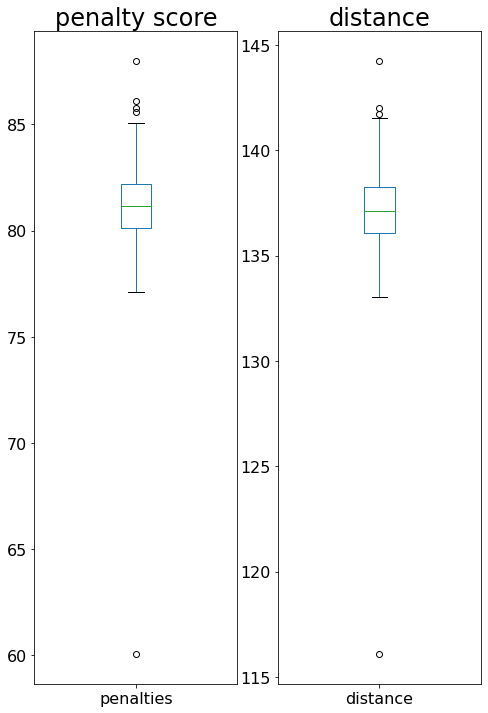

In [47]:

# plotje = grafiekje[['penalties', 'distance']].plot(subplots=True, kind='box', fontsize=14, figsize=(8,12))
# plotje.set_title('Distribution of penalties\n of 1000 random runs', fontsize=16)
# plotje.set_ylabel('penalty score', fontsize=14)
# plotje.figure.savefig('penalties.pdf')
# plotje.figure.savefig('penalties.png', bbox_inches='tight')

# fig, axes = plt.subplots(1,2, figsize=(6,6))
# plt.subplots_adjust(wspace=0.5, hspace=0.5)
plotje = grafiekje[['penalties', 'distance']].plot(subplots=True, kind='box', fontsize=16, figsize=(8,12))
plotje[0].set_title('penalty score', size=24)
plotje[1].set_title('distance', size=24)
plotje[0].get_figure().savefig('penalty_score.pdf')
plotje[0].get_figure().savefig('distance.pdf')

In [ ]:
def best_of_random(num_iterations, joined, all_households, rel_poi_df,
                   df_afstandn2, clean=True, use_count=False,
                   return_all=False):
    """
    Perform multiple random creations and save best result.

    Create multiple random candidate solutions and return the best one of these
    Num_iterations decides the amount of iterations. The best option is always
    returned and can also be the standard solution that is also included in the
    options. The best of random can subsequently used as input for some kind of
    iterative optimization process(hillclimber for example).
    """
    result_dict = {}    
    
    joined_cluster_distance, good_result_rich, aansluitingen, avg_distance, \
        penalties, simple_penalties = \
        analyze_candidate_solution(joined, all_households, rel_poi_df,
                                   df_afstandn2, clean=clean,
                                   use_count=use_count, return_all=return_all)
    best = 0
    result_dict[0] = [avg_distance, penalties, simple_penalties]

    for i in range(1, num_iterations + 1):
        joined2 = random_shuffling_clusters(joined)
        joined_cluster_distance2, good_result_rich2, \
            aansluitingen2, avg_distance2, penalties2, simple_penalties2 = \
            analyze_candidate_solution(joined2, all_households, rel_poi_df,
                                       df_afstandn2, clean=clean,
                                       use_count=use_count,
                                       return_all=return_all)
        result_dict[i] = [avg_distance2, penalties2, simple_penalties2]
        
        if penalties2 < penalties:
            joined = joined2
            joined_cluster_distance = joined_cluster_distance2
            good_result_rich = good_result_rich2
            aansluitingen = aansluitingen2
            avg_distance = avg_distance2
            penalties = penalties2
            simple_penalties = simple_penalties2
            best = i

    print('***************************************')
    print(avg_distance, penalties, best)
    return result_dict

results = best_of_random(3, joined, all_households, rel_poi_df, df_afstandn2, clean=False, use_count=True, return_all=False)

In [ ]:
results

### Change in walking distances for households

In [9]:
from bokeh.plotting import figure, show, save
from bokeh.models import GeoJSONDataSource, ColumnDataSource, HoverTool, ColorBar, LinearColorMapper, BasicTicker
from bokeh.io import export_png
from bokeh.palettes import RdYlGn10

import matplotlib.cm as cm
import numpy as np

In [10]:
good_result0 = good_result[good_result['rest_afstand'].isna()]
good_result0['weighted_distance'] = - (\
+ good_result0['plastic_afstand'] * 0.089 + good_result0['papier_afstand'] * 0.16\
+ good_result0['glas_afstand'] * 0.11 + good_result0['textiel_afstand'] * 0.025) / 0.39

good_result1 = good_result[good_result['rest_afstand'] > 0]
good_result1['weighted_distance'] = -(good_result1['rest_afstand'] * 0.61\
+ good_result1['plastic_afstand'] * 0.089 + good_result1['papier_afstand'] * 0.16\
+ good_result1['glas_afstand'] * 0.11 + good_result1['textiel_afstand'] * 0.025)

good_result = good_result0.append(good_result1)
good_result = good_result[good_result['count'] > 0]

<ipython-input-10-01b8a7507f3b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_result0['weighted_distance'] = - (\
<ipython-input-10-01b8a7507f3b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_result1['weighted_distance'] = -(good_result1['rest_afstand'] * 0.61\


In [15]:
colormap = cm.get_cmap("RdYlGn")
colorspan = [-200, 0]
cmap_input = np.interp(good_result['weighted_distance'], colorspan, [0,1])
A_color = colormap(cmap_input, 1, True)
bokeh_colors = ["#%02x%02x%02x" % (r, g, b) for r, g, b in A_color[:,0:3]]
good_result['colors'] = bokeh_colors
good_result['weighted_distance'] = - good_result['weighted_distance']

source1 = ColumnDataSource(data=good_result)

TOOLTIPS2 = [
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Count", "@count"),
            ("Rest distance", "@rest_afstand"),
            ("Plastic distance", "@plastic_afstand"),
            ("Paper distance", "@papier_afstand"),
            ("Glass distance", "@glas_afstand"),
            ("Textile distance", "@textiel_afstand"),
            ("Weighted distance", "@weighted_distance")]

In [16]:
p = figure(match_aspect=True)
r3 = p.circle(x='cluster_x', y='cluster_y', fill_color='colors', line_color=None,
              source=source1, radius=7)
p.add_tools(HoverTool(renderers=[r3], tooltips=TOOLTIPS2))

show(p)

### Now to try a very good solution

In [17]:
df1 = pd.read_csv('../Results/20200604 - long run/hillclimber_best_config20200603-2045.csv')
df2 = pd.read_csv('../Results/20200604 - long run/hillclimber_best_config20200604-0133.csv')
df3 = pd.read_csv('../Results/20200604 - long run/hillclimber_best_config20200604-0824.csv')
df4 = pd.read_csv('../Results/20200604 - long run/hillclimber_best_config20200605-0003.csv')
df5 = joined[joined['stadsdeel'] == 'E']
df = df1.append([df2, df3, df4, df5]).drop('Unnamed: 0', axis=1)

to_join = df[['s1_afv_nodes', 'rest', 'plastic', 'papier', 'glas',
                 'textiel', 'totaal']].set_index('s1_afv_nodes')
joined.s1_afv_nodes = joined.s1_afv_nodes.astype('int')
new = to_join.join(joined.set_index('s1_afv_nodes'), lsuffix='_n')

In [18]:
joined_cluster_distance2 = df.set_index('s1_afv_nodes')\
    .join(df_afstandn2.set_index('van_s1_afv_nodes')).reset_index()\
    .rename(columns={'index':'van_s1_afv_nodes'})

In [19]:
good_result2 = add_shortest_distances_to_all_households(all_households,
                                                       joined_cluster_distance2,
                                                       use_count=True)
good_result2 = good_result2[good_result2['count'] > 0]

In [42]:
def visualize_households(good_result, new, name='dummy'):
    
    street_map = gpd.read_file('../data/Inzameling_huisvuil_100220.shp')
    geosource = GeoJSONDataSource(geojson=street_map.to_json())
    street_map_clean = \
        street_map[street_map['aanbiedwij'] ==
                   'Breng uw restafval  naar een container voor restafval.']
    geosource2 = GeoJSONDataSource(geojson=street_map_clean.to_json())
    
    
    good_result2 = good_result[(good_result['rest_afstand'].isna()) & (good_result['papier_afstand'].isna())]
    good_result2['weighted_distance'] = -(\
    + good_result2['plastic_afstand'] * 0.089 + \
    + good_result2['glas_afstand'] * 0.11 + good_result2['textiel_afstand'] * 0.025) / 0.23
    
    good_result0 = good_result[(good_result['rest_afstand'].isna()) & ~(good_result['papier_afstand'].isna())]
    good_result0['weighted_distance'] = -(\
    + good_result0['plastic_afstand'] * 0.089 + good_result0['papier_afstand'] * 0.16\
    + good_result0['glas_afstand'] * 0.11 + good_result0['textiel_afstand'] * 0.025) / 0.39

    good_result1 = good_result[((good_result['rest_afstand'] >= 0) | (good_result['rest_afstand'] < 0)) & ~(good_result['papier_afstand'].isna())]
    good_result1['weighted_distance'] =-(good_result1['rest_afstand'] * 0.61\
    + good_result1['plastic_afstand'] * 0.089 + good_result1['papier_afstand'] * 0.16\
    + good_result1['glas_afstand'] * 0.11 + good_result1['textiel_afstand'] * 0.025)

    good_result = good_result0.append(good_result1)
    good_result = good_result[good_result['count'] > 0]

    ##################################
    color_mapper = LinearColorMapper(palette=RdYlGn10, low=-50, high=50)
    color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), label_standoff=4, location=(0,0))
    ##################################
    
    colormap = cm.get_cmap("RdYlGn")
    colorspan = [-50, 50]
    cmap_input = np.interp(good_result['weighted_distance'], colorspan, [0,1])
    A_color = colormap(cmap_input, 1, True)
    bokeh_colors = ["#%02x%02x%02x" % (r, g, b) for r, g, b in A_color[:,0:3]]
    good_result['colors'] = bokeh_colors
    good_result['weighted_distance'] = - good_result['weighted_distance']

    source1 = ColumnDataSource(data=good_result)
    source2 = ColumnDataSource(data=new
                               [['cluster_x', 'cluster_y', 'rest', 'papier',
                                 'plastic', 'textiel', 'glas', 'rest_n',
                                 'papier_n', 'glas_n', 'plastic_n',
                                 'textiel_n']])

    TOOLTIPS = [
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Rest", "(@rest, @rest_n)"),
            ("Plastic", "(@plastic, @plastic_n)"),
            ("Papier", "(@papier, @papier_n)"),
            ("Glas", "(@glas, @glas_n)"),
            ("Textiel", "(@textiel, @textiel_n)")
            ]
    
    TOOLTIPS2 = [
                ("index", "$index"),
                ("(x,y)", "($x, $y)"),
                ("Count", "@count"),
                ("Rest distance", "@rest_afstand"),
                ("Plastic distance", "@plastic_afstand"),
                ("Paper distance", "@papier_afstand"),
                ("Glass distance", "@glas_afstand"),
                ("Textile distance", "@textiel_afstand"),
                ("Weighted distance", "@weighted_distance")]
    
    
    p = figure(width=500, height=400, x_range=(110000, 135000), y_range=(475000, 495000), title='Change in weighted walking distance by' + name)
    p.axis.visible = False
    
    p.patches('xs', 'ys', source=geosource, fill_color='grey', alpha=0.1,
              line_color=None)
    p.patches('xs', 'ys', source=geosource2, fill_color='grey', alpha=0.3,
              line_color=None)

    r4 = p.circle(x='cluster_x', y='cluster_y', color='black', line_color=None,
              source=source2, radius=10)
    p.add_tools(HoverTool(renderers=[r4], tooltips=TOOLTIPS))
 
    r3 = p.circle(x='cluster_x', y='cluster_y', fill_color='colors', line_color=None,
                  source=source1, radius=12, alpha=0.5)
    p.add_tools(HoverTool(renderers=[r3], tooltips=TOOLTIPS2))
    
    p.add_layout(color_bar, 'right')

    show(p)
    save(p, name+'.html')
    return p

In [43]:
# visualize_households(good_result, new, name='initial solution')
# visualize_households(good_result2, new)
# visualize_households(jj)
# visualize_households(good_result3, newest, name=' Gaussian')
visualize_households(jj2, new, name=' difference 2-opt - initial')
visualize_households(jj3, newest, name=' difference Gaussian - initial')

<ipython-input-42-5aa5ea1037d3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_result2['weighted_distance'] = -(\
<ipython-input-42-5aa5ea1037d3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_result0['weighted_distance'] = -(\
<ipython-input-42-5aa5ea1037d3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Figure(id='6517', ...)

In [21]:
jj = good_result.join(good_result2, rsuffix='_new', lsuffix='_old', how='inner')
jj['rest_afstand'] = jj['rest_afstand_new'] - jj['rest_afstand_old']
jj['plastic_afstand'] = jj['plastic_afstand_new'] - jj['plastic_afstand_old']
jj['papier_afstand'] = jj['papier_afstand_new'] - jj['papier_afstand_old']
jj['glas_afstand'] = jj['glas_afstand_new'] - jj['glas_afstand_old']
jj['textiel_afstand'] = jj['textiel_afstand_new'] - jj['textiel_afstand_old']
jj['count'] = jj['count_old']
jj['cluster_x'] = jj['cluster_x_old']
jj['cluster_y'] = jj['cluster_y_old']

# jj = jj.dropna(subset=['cluster_x_old', 'cluster_x_new'])

In [ ]:
visualize_households(jj, new, name='Gaussian hillclimber without West')

In [22]:
good_result2[good_result2['uses_container']]['rest_afstand'] = np.nan

<ipython-input-22-01dd2b65647c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_result2[good_result2['uses_container']]['rest_afstand'] = np.nan


### Results of 2-opt

In [23]:
two_opt = pd.read_csv('../Results/20200522 - figures for thesis/2opt optimalisatie/hillclimber_best_config20200608-1404.csv')
to_join2 = two_opt[['s1_afv_nodes', 'rest', 'plastic', 'papier', 'glas',
                 'textiel', 'totaal']].set_index('s1_afv_nodes')
joined.s1_afv_nodes = joined.s1_afv_nodes.astype('int')
new = to_join2.join(joined.set_index('s1_afv_nodes'), lsuffix='_n')

In [24]:
joined_cluster_distance3 = two_opt.set_index('s1_afv_nodes')\
    .join(df_afstandn2.set_index('van_s1_afv_nodes')).reset_index()\
    .rename(columns={'index':'van_s1_afv_nodes'})

good_result3 = add_shortest_distances_to_all_households(all_households,
                                                       joined_cluster_distance3,
                                                       use_count=True)
good_result3 = good_result3[good_result3['count'] > 0]

In [25]:
jj2 = good_result.join(good_result3, rsuffix='_new', lsuffix='_old', how='inner')
jj2['rest_afstand'] = jj2['rest_afstand_new'] - jj2['rest_afstand_old']
jj2['plastic_afstand'] = jj2['plastic_afstand_new'] - jj2['plastic_afstand_old']
jj2['papier_afstand'] = jj2['papier_afstand_new'] - jj2['papier_afstand_old']
jj2['glas_afstand'] = jj2['glas_afstand_new'] - jj2['glas_afstand_old']
jj2['textiel_afstand'] = jj2['textiel_afstand_new'] - jj2['textiel_afstand_old']
jj2['count'] = jj['count_old']
jj2['cluster_x'] = jj2['cluster_x_old']
jj2['cluster_y'] = jj2['cluster_y_old']

In [ ]:
visualize_households(jj2, new, name=' 2-opt')

### Newest optimization

In [26]:
df1 = pd.read_csv('../Results/20200612 - long run/hillclimber_best_config20200610-1938.csv')
df2 = pd.read_csv('../Results/20200612 - long run/hillclimber_best_config20200611-0023.csv')
df3 = pd.read_csv('../Results/20200612 - long run/hillclimber_best_config20200611-0720.csv')
df4 = pd.read_csv('../Results/20200612 - long run/hillclimber_best_config20200612-0255.csv')
df5 = joined[joined['stadsdeel'] == 'E']
df_newest = df1.append([df2, df3, df4, df5]).drop('Unnamed: 0', axis=1)

to_join_newest = df_newest[['s1_afv_nodes', 'rest', 'plastic', 'papier', 'glas',
                 'textiel', 'totaal']].set_index('s1_afv_nodes')
joined.s1_afv_nodes = joined.s1_afv_nodes.astype('int')
newest = to_join_newest.join(joined.set_index('s1_afv_nodes'), lsuffix='_n')

In [27]:
joined_cluster_distance3 = df_newest.set_index('s1_afv_nodes')\
    .join(df_afstandn2.set_index('van_s1_afv_nodes')).reset_index()\
    .rename(columns={'index':'van_s1_afv_nodes'})

In [28]:
good_result3 = add_shortest_distances_to_all_households(all_households,
                                                       joined_cluster_distance3,
                                                       use_count=True)
good_result3 = good_result3[good_result3['count'] > 0]

In [ ]:
visualize_households(good_result3, newest, name=' Gaussian')

In [29]:
good_result3.loc[~good_result3['uses_container'],
                        'rest_afstand'] = np.nan
good_result3.loc[~good_result3['uses_container'], 'poi_rest'] = np.nan

good_result3.loc[good_result3['collect_cardboard'], 'papier_afstand'] = np.nan
good_result3.loc[good_result3['collect_cardboard'], 'poi_papier'] = np.nan

In [30]:
jj3 = good_result.join(good_result3, rsuffix='_new', lsuffix='_old', how='inner')
jj3['rest_afstand'] = jj3['rest_afstand_new'] - jj3['rest_afstand_old']
jj3['plastic_afstand'] = jj3['plastic_afstand_new'] - jj3['plastic_afstand_old']
jj3['papier_afstand'] = jj3['papier_afstand_new'] - jj3['papier_afstand_old']
jj3['glas_afstand'] = jj3['glas_afstand_new'] - jj3['glas_afstand_old']
jj3['textiel_afstand'] = jj3['textiel_afstand_new'] - jj3['textiel_afstand_old']
jj3['count'] = jj3['count_old']
jj3['cluster_x'] = jj3['cluster_x_old']
jj3['cluster_y'] = jj3['cluster_y_old']

# jj = jj.dropna(subset=['cluster_x_old', 'cluster_x_new'])

In [56]:
number_households = good_result['count'].sum()
number_households - 329 * 750

161580.0

In [64]:
(206130 * 0.089 + 27797 * 0.16 + 141130 * 0.11 + 161580 * 0.025) * 100 / number_households

10.373200597555899

In [65]:
from Code.algorithms import random_start_hillclimber

%time hill_df, best = random_start_hillclimber(joined, all_households, rel_poi_df, df_afstandn2, clean=False, prompt=False)

Average distance is : 116.08608930901478
Penalties are: 60.05932817875248
Simple penalties are: 217339.18800000002


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\corne\anaconda3\envs\geo_env\lib\site-packages\IPython\core\magics\execution.py", line 1312, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "..\Code\algorithms.py", line 221, in random_start_hillclimber
    best_of_random(i, joined, all_households, rel_poi_df, df_afstandn2,
  File "..\Code\algorithms.py", line 80, in best_of_random
    analyze_candidate_solution(joined2, all_households, rel_poi_df,
  File "..\Code\helper_functions.py", line 491, in analyze_candidate_solution
    add_shortest_distances_to_all_households(all_households,
  File "..\Code\helper_functions.py", line 343, in add_shortest_distances_to_all_households
    shortest_rest = cluster_distance_matrix[cluster_distance_matrix['rest'] > 0].\
  File "C:\Users\corne\anaconda3\envs\geo_env\lib\site-packages\pandas\core\groupby\groupby.py", line 1371, in f
    return self._cython_agg_general(alias, alt=npfunc, **kwargs)
  File "C:\U

KeyboardInterrupt: 